<p style="text-align:center"> 
    <a href="https://www.linkedin.com/in/flavio-aguirre-12784a252/" target="_blank"> 
    <img src="../assets/logo.png" width="200" alt="Flavio Aguirre Logo"> 
    </a>
</p>

<h1 align="center"><font size="7"><strong>📉 ByeBye Predictor</strong></font></h1>
<br>
<hr>

## Modeling TELCO features

Returning to the previous labs, we can see that we have two documented measurements using the same model (RandomForest):

| Metric | Baseline (31 vars) | Model with new features (37 vars) |
| ---------- | ------------------------- | ---------------------------------- |
| Accuracy | 0.7863 | 0.7844 |
| Precision | 0.6273 | 0.6250 |
| ``Recall`` | ``0.4831`` | ``0.4724`` |
| F1 score | 0.5458 | 0.5381 |

We have also seen that a low recall implies a high cost for the business, as it means losing customers without having identified them in time to take preventive measures and prevent their departure. Therefore, it is essential to improve this aspect to anticipate and act accordingly.

``Objective``: In this notebook, we will train and compare all models using the 37 available variables. We will then apply advanced optimization techniques to improve their performance and maximize the system's predictive capacity.

In [3]:
import joblib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve
)
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Visual style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

<hr>

### Loading the dataset with the new features

In [5]:
df = pd.read_csv('../data/processed/telco-feature-engineering.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tenure                                7032 non-null   float64
 1   monthlycharges                        7032 non-null   float64
 2   totalcharges                          7032 non-null   float64
 3   gender_male                           7032 non-null   bool   
 4   seniorcitizen_yes                     7032 non-null   bool   
 5   partner_yes                           7032 non-null   bool   
 6   dependents_yes                        7032 non-null   bool   
 7   phoneservice_yes                      7032 non-null   bool   
 8   multiplelines_no_phone_service        7032 non-null   bool   
 9   multiplelines_yes                     7032 non-null   bool   
 10  internetservice_fiber_optic           7032 non-null   bool   
 11  internetservice_n

### Splitting the training and test sets

In [6]:
X = df.drop(columns='churn')
y = df['churn']

### Splitting into training and test sets

In previous labs, we reserved 30% of the data for the test set. This time, we'll reduce that proportion to 20% to provide the model with more training data. This way, we'll evaluate whether having more information during training allows the model to generalize better and improve its performance.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,  # 20% for test set
    random_state=42, 
    stratify=y
)

### We train the models

* ``Model 1: Logistic regression``

In [8]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

* ``Model 2: Decision tree``

In [9]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

* ``Model 3: RandomForest``

In [10]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

* ``Model 4: Support Vector Machine (SVM)``

In [11]:
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

* ``Model 5: XGBoost``

In [12]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### Model Evaluation

We evaluate the new results

In [13]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Some versions of SVM don't have predict_proba enabled by default
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except:
        y_proba = None
        auc = "N/A"

    print(f"\nModel: {model.__class__.__name__} with feature engineering")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", auc) 
    print("-" * 40) 

    cm = confusion_matrix(y_test, y_pred) 
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Churn", "Churn"]) 
    disp.plot(cmap="Blues") 
    plt.title(f"Confusion Matrix - {model.__class__.__name__} with feature engineering") 
    plt.savefig(f"../reports/figures/telco-model-feature-eng/confusion_matrix_{model.__class__.__name__}_feature_engineering.png") 
    plt.show()


Model: LogisticRegression with feature engineering
Accuracy: 0.8038379530916845
Precision: 0.6484848484848484
Recall: 0.5721925133689839
F1 Score: 0.6079545454545454
AUC-ROC: 0.8375053708890051
----------------------------------------


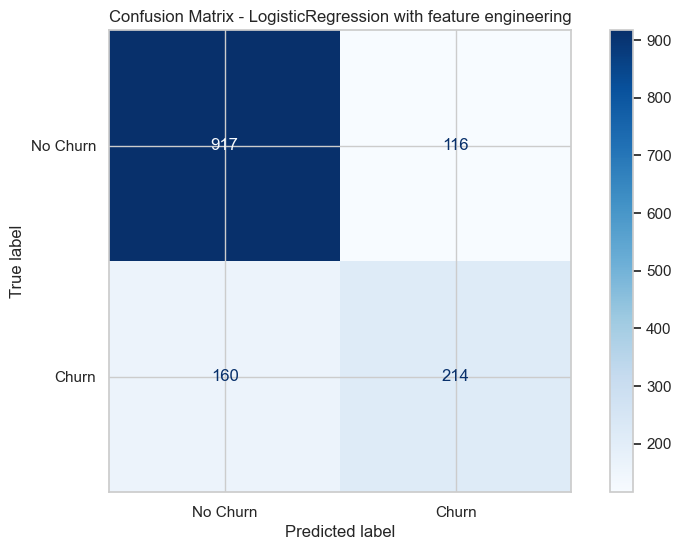


Model: DecisionTreeClassifier with feature engineering
Accuracy: 0.7249466950959488
Precision: 0.48320413436692505
Recall: 0.5
F1 Score: 0.4914586070959264
AUC-ROC: 0.6529525653436592
----------------------------------------


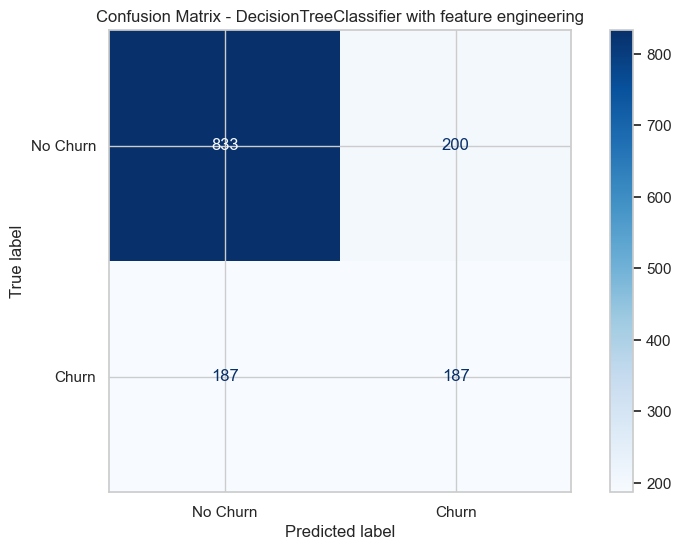


Model: RandomForestClassifier with feature engineering
Accuracy: 0.783226723525231
Precision: 0.6146179401993356
Recall: 0.4946524064171123
F1 Score: 0.5481481481481482
AUC-ROC: 0.815452371215141
----------------------------------------


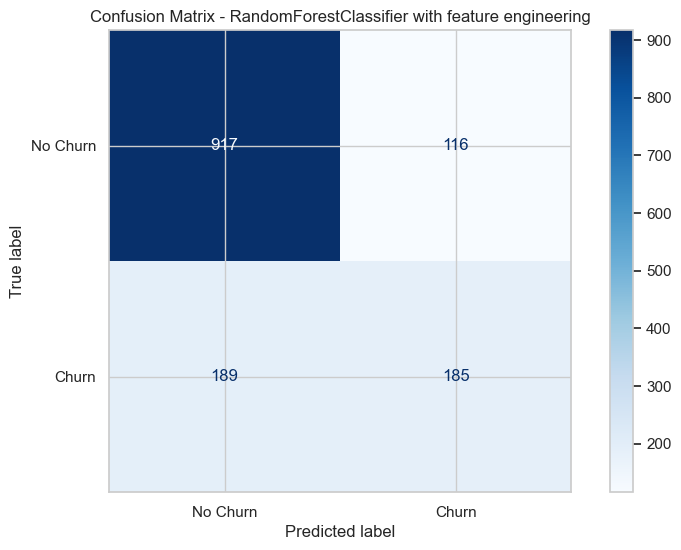


Model: SVC with feature engineering
Accuracy: 0.7803837953091685
Precision: 0.6382978723404256
Recall: 0.40106951871657753
F1 Score: 0.49261083743842365
AUC-ROC: 0.8314847984428304
----------------------------------------


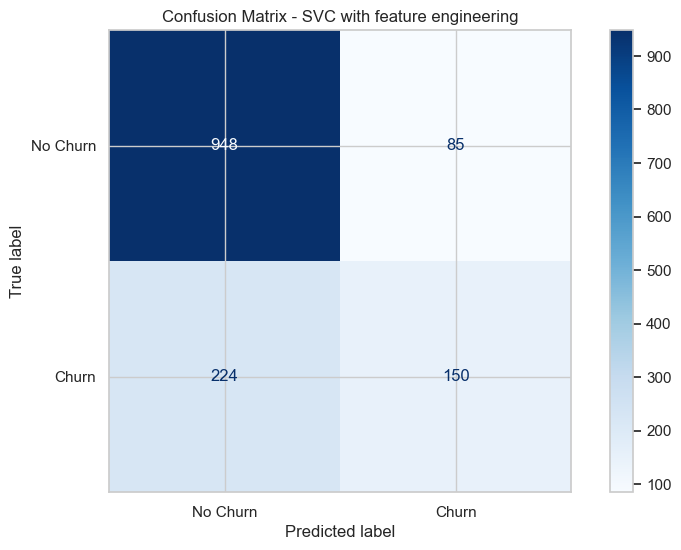


Model: XGBClassifier with feature engineering
Accuracy: 0.7803837953091685
Precision: 0.5936599423631124
Recall: 0.5508021390374331
F1 Score: 0.5714285714285714
AUC-ROC: 0.8190178650004399
----------------------------------------


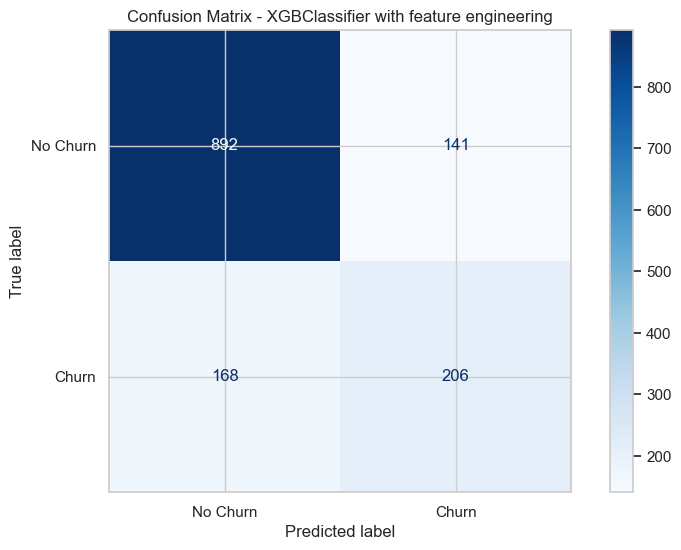

In [14]:
models = [log_model, tree_model, rf_model, svm_model, xgb_model]

for model in models:
    evaluate_model(model, X_test, y_test)

### Conclusions with the new features (without optimizing the models)

While some general metrics experienced a slight decrease, we observed a significant improvement in certain models: ``Logistic Regression, Decision Tree, and XGBoost``, the metric of most interest to us, recall.

For this reason, we will focus on these three models for the next stage, in which we will apply advanced optimization and tuning techniques (such as GridSearch and resampling) to further enhance their performance on this enriched dataset.

<br>

# Model optimization

It's important to remember that our dataset has already been preprocessed, except for the new variables. Therefore, it's not necessary to rescale all the features. It's worth noting that six new variables have been created, two of which are numeric and have not yet been scaled. We'll now scale them accordingly to properly integrate them into the model.

In [15]:
# The two new numeric columns to scale
new_num_cols = ['avg_monthly_spend', 'num_services']

# All other columns
other_cols = X.columns.difference(new_num_cols).tolist()

# Preprocessor: scale only new numerics
preprocessor = ColumnTransformer([
    ('scale_new', StandardScaler(), new_num_cols),     # Scale only new ones
    ('keep_others', 'passthrough', other_cols)         # Leave the rest the same
])

<br>

### We train the models

Our goal is to maximize the detection of customers close to churn (recall), ensuring that the model identifies as many churn cases as possible. This will allow us to anticipate and implement preventive actions, reducing the financial impact.

We will focus on improving this metric without unduly sacrificing others such as accuracy, seeking a balance that is effective and sustainable for the business.

* ``Model 1: Logistic regression``

In [16]:
# Define pipeline
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

# Hyperparameter Grid
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

# Grid search
lr_grid = GridSearchCV(
    lr_pipeline, lr_param_grid,
    cv=5, scoring='recall', n_jobs=-1
)
lr_grid.fit(X, y)

print("Best parameters (LogisticRegression):", lr_grid.best_params_)
print("Best recall:", lr_grid.best_score_)

Best parameters (LogisticRegression): {'classifier__C': 10, 'classifier__penalty': 'l1'}
Best recall: 0.8015010537483332


``Unbelievable but true``: We went from a ``recall of 0.5721`` with the unoptimized model and using all variables, to a ``recall of 0.8015`` after applying GridSearch and resampling techniques (SMOTE). This improvement reflects the positive impact of tuning hyperparameters and balancing classes to enhance the model's ability to detect customers at risk of churn.

<br>

* ``Model 2: Decision tree``

In [17]:
dt_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

dt_param_grid = {
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(
    dt_pipeline, dt_param_grid,
    cv=5, scoring='recall', n_jobs=-1
)
dt_grid.fit(X, y)

print("Best parameters (DecisionTree):", dt_grid.best_params_)
print("Best recall:", dt_grid.best_score_)

Best parameters (DecisionTree): {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best recall: 0.7806454387750713


* ``Model 3: XGBoost``

In [18]:
# Calculate ratio for scale_pos_weight
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss'))
])

xgb_param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__n_estimators': [100, 200]
}

xgb_grid = GridSearchCV(
    xgb_pipeline, xgb_param_grid,
    cv=5, scoring='recall', n_jobs=-1
)
xgb_grid.fit(X, y)

print("Best parameters (XGBoost):", xgb_grid.best_params_)
print("Best recall:", xgb_grid.best_score_)

Best parameters (XGBoost): {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best recall: 0.9662929563733853


With XGBoost, the model achieves outstanding performance, achieving a recall of 0.96, a truly exceptional metric.

It's important to note that this value corresponds to the average of all folds during cross-validation, which lends robustness to the result. Still, it's prudent to analyze this performance in detail to understand whether it represents a consistent improvement or if there could be signs of overfitting.

We evaluated XGBoost with our test suite to understand this result.

In [19]:
# Predict in test
y_pred = xgb_grid.best_estimator_.predict(X_test)

# Verify recall in test
recall = recall_score(y_test, y_pred)
print(f"Recall en test: {recall:.4f}")

# Full report
print(classification_report(y_test, y_pred))

Recall en test: 0.9679
              precision    recall  f1-score   support

           0       0.97      0.42      0.58      1033
           1       0.38      0.97      0.54       374

    accuracy                           0.56      1407
   macro avg       0.67      0.69      0.56      1407
weighted avg       0.81      0.56      0.57      1407



### ***Report result***

**``Model Strengths``**:

Recall for the churn class (97%): We see that the model is able to detect almost all customers who actually churn (374 * 97% ≈ 363 detected). This is critical in the business, as it allows us to take preventive action (retention, personalized offers, etc.).

**``Model Weaknesses``**:

Accuracy for the churn class (38%): Of all the customers the model predicted as "churn," only 38% actually churned. This implies a high rate of false positives (customers considered at risk but who would not actually churn).

Recall for the non-churn class (42%): The model struggles to correctly identify loyal customers. In other words, it misclassifies many non-churn customers as churn.

**``Imbalance Impact``**:

The non-churn class has more than twice as many examples (1,033 vs. 374). The model appears to be biased toward predicting the minority (churn) class, sacrificing performance in the majority class.

<br>

***Why did this happen?***

Because during the search for the best model using GridSearch, the metric "Recall" was used.

This means that the optimization process prioritized exclusively maximizing recall, that is, minimizing false negatives. As a result, the model learned to be very aggressive in detecting at-risk customers, but at the cost of generating many false positives.

What will we do to improve the balance?

To achieve a more balanced model, we will now choose to use the following optimization metric:
``scoring = 'f1'``.

The F1 score is the harmonic mean between precision and recall, which means that to improve this metric, the model must find a good compromise between:

* Correctly detecting customers who abandon (high recall),

* And not misclassifying many loyal customers as churners (high precision).

<br>

### Retraining with ``f1-score`` criteria

* ``Model 1: Logistic regression``

In [20]:
# Define pipeline
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

# Hyperparameter Grid
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

# Grid search
lr_grid = GridSearchCV(
    lr_pipeline, lr_param_grid,
    cv=5, scoring='f1', n_jobs=-1
)
lr_grid.fit(X, y)

print("Best parameters (LogisticRegression):", lr_grid.best_params_)
print("Best f1:", lr_grid.best_score_)

Best parameters (LogisticRegression): {'classifier__C': 10, 'classifier__penalty': 'l2'}
Best f1: 0.6321413632384263


* ``Model 2: Decision tree``

In [21]:
dt_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

dt_param_grid = {
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(
    dt_pipeline, dt_param_grid,
    cv=5, scoring='f1', n_jobs=-1
)
dt_grid.fit(X, y)

print("Best parameters (DecisionTree):", dt_grid.best_params_)
print("Best f1:", dt_grid.best_score_)

Best parameters (DecisionTree): {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Best f1: 0.6056385572334024


* ``Model 3: XGBoost``

In [22]:
# Calculate ratio for scale_pos_weight
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss'))
])

xgb_param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__n_estimators': [100, 200]
}

xgb_grid = GridSearchCV(
    xgb_pipeline, xgb_param_grid,
    cv=5, scoring='f1', n_jobs=-1
)
xgb_grid.fit(X, y)

print("Best parameters (XGBoost):", xgb_grid.best_params_)
print("Best f1:", xgb_grid.best_score_)

Best parameters (XGBoost): {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best f1: 0.6164250801754874


We re-evaluate our selected models:

In [23]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Some versions of SVM don't have predict_proba enabled by default
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except:
        y_proba = None
        auc = "N/A"

    print(f"\nModel: {model.steps[-1][1].__class__.__name__}-{model.__class__.__name__} with feature engineering")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", auc) 
    print("-" * 40) 

    cm = confusion_matrix(y_test, y_pred) 
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Churn", "Churn"]) 
    disp.plot(cmap="Blues") 
    plt.title(f"Confusion Matrix - {model.steps[-1][1].__class__.__name__}-{model.__class__.__name__} with feature engineering") 
    plt.savefig(f"../reports/figures/telco-model-optimization/confusion_matrix_{model.steps[-1][1].__class__.__name__}-{model.__class__.__name__}_feature_engineering.png") 
    plt.show()


Model: LogisticRegression-Pipeline with feature engineering
Accuracy: 0.7299218194740583
Precision: 0.49503311258278143
Recall: 0.7994652406417112
F1 Score: 0.6114519427402862
AUC-ROC: 0.8396640800120101
----------------------------------------


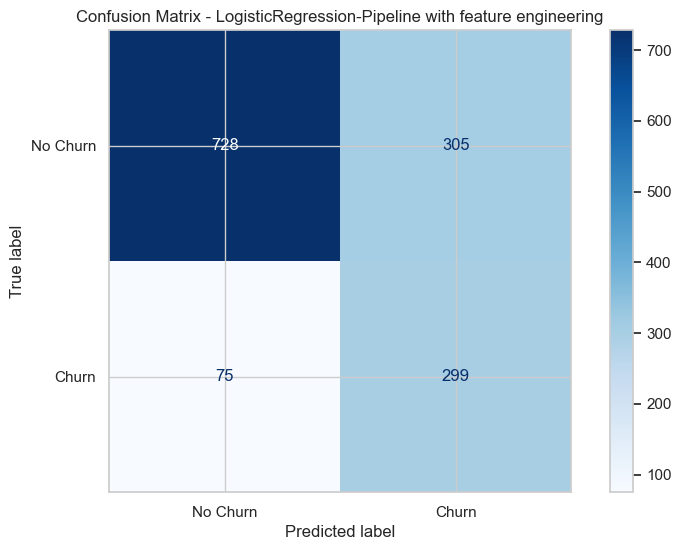


Model: DecisionTreeClassifier-Pipeline with feature engineering
Accuracy: 0.7270788912579957
Precision: 0.49166666666666664
Recall: 0.7887700534759359
F1 Score: 0.6057494866529775
AUC-ROC: 0.8246255907977907
----------------------------------------


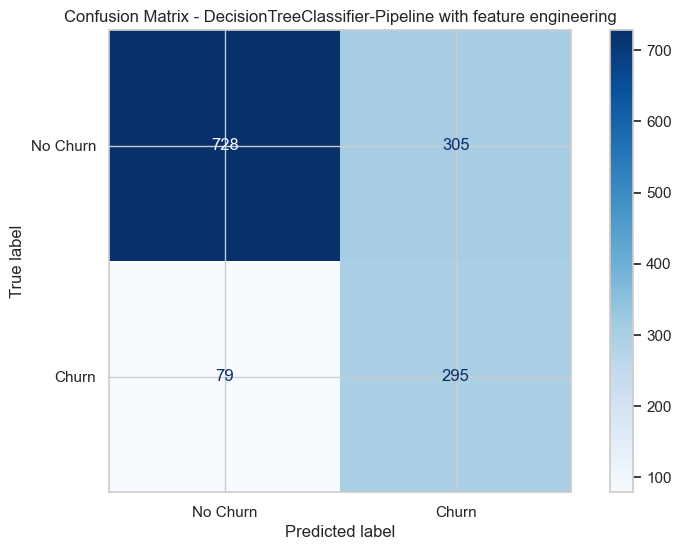


Model: XGBClassifier-Pipeline with feature engineering
Accuracy: 0.7313432835820896
Precision: 0.49697885196374625
Recall: 0.8796791443850267
F1 Score: 0.6351351351351351
AUC-ROC: 0.8649564375605033
----------------------------------------


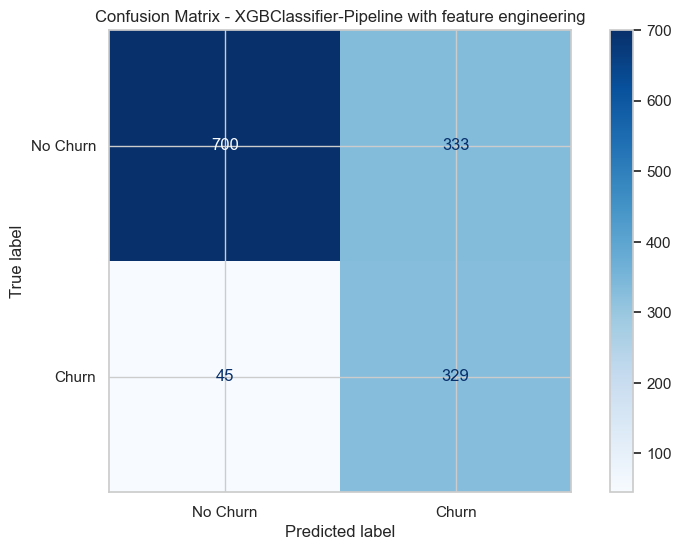

In [24]:
best_models = [lr_grid.best_estimator_, dt_grid.best_estimator_, xgb_grid.best_estimator_]

for model in best_models:
    evaluate_model(model, X_test, y_test)

<br>

### Conclusions from this lab

**Overall Performance**
* XGBoost stands out as the most powerful model of the three, with an outstanding ``recall of 0.87 and an AUC-ROC of 0.86``, indicating a very good ability to correctly distinguish between churning and remaining customers.

* The other models, although with very similar results, lag slightly behind. Both Logistic Regression and Decision Tree achieve recalls close to 0.79, but slightly sacrifice overall balance (lower F1 and AUC-ROC compared to XGBoost).

**Results**
* We've managed to get all models to detect a high proportion of churn, which is critical in business terms.
* The feature engineering phase had a positive impact, allowing even simple models like Logistic Regression to achieve robust metrics.
* XGBoost excels and is our flagship model.

The next stage will be feature selection, where we will refine the variables to simplify the model, reduce noise, and find an even better balance between recall and precision. With these results, we are very close to a model with high-level predictive capacity.

<br>

### We save the pipelines

In [26]:
best_models = [lr_grid.best_estimator_, dt_grid.best_estimator_, xgb_grid.best_estimator_]

for model in best_models:
    joblib.dump(model, f'../models/pipelines/{model.steps[-1][1].__class__.__name__}-{model.__class__.__name__}.pkl')

print("Pipelines saved successfully.")

Pipelines saved successfully.


<hr>

## Author

<a href="https://www.linkedin.com/in/flavio-aguirre-12784a252/">**Flavio Aguirre**</a>
<br>
<a href="https://coursera.org/share/e27ae5af81b56f99a2aa85289b7cdd04">***Data Scientist***</a>